<a href="https://colab.research.google.com/github/akatari2024-debug/Augmentation-pytorch3d-assignment/blob/main/Augmented_reality_with_PyTorch3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In a Colab cell, run this to install PyTorch3D and other dependencies
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.3.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D from a pre-compiled wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source, this may take a while.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

!pip install opencv-python matplotlib

# General imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-th_adc4q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-th_adc4q
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl size=56425577 sha256=42b1d3634011f787d88e6054c5670c54c2e88f2659e4e421a33a283c721fa47a
  Stored in directory: /tmp/pip-ephem-wheel-cache-27w7p9js/wheels/e9/ec/88/13a99edfc9de29485b221df3503c3bca62e23abac9f2b3a974
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=4b7831628f98363c5eeddf5

/bin/bash: line 1: wget/content/IMG_5108.DNG: No such file or directory
Image size: width=4816, height=4621


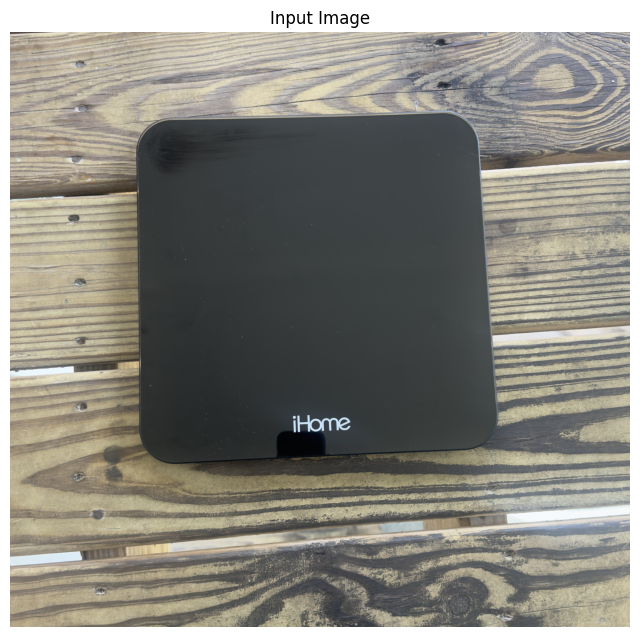

In [8]:
# Download a sample image to make the notebook reproducible
!wget/content/IMG_5108.DNG
# Load the image using OpenCV
image_path = '/content/IMG_5108.DNG'
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width, _ = image_rgb.shape
print(f"Image size: width={width}, height={height}")

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.title("Input Image")
plt.axis('off')
plt.show()

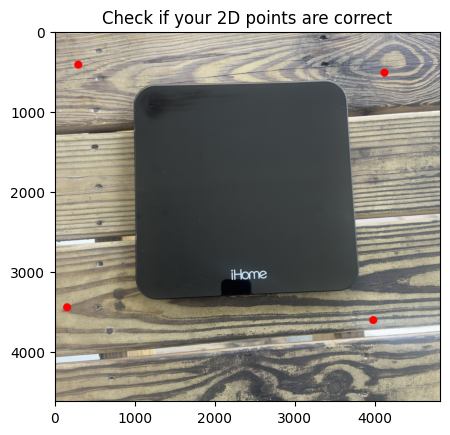

In [9]:
# 1. Enter the real-world dimensions of your object (e.g., in cm).
object_width_cm = 15.0 # UPDATE THIS
object_height_cm = 15.0 # UPDATE THIS

# 2. Enter the pixel coordinates you found for the four corners.
# Make sure the order is correct!
image_points_2d = np.array([
    [290, 420],   # Top-left <--- REPLACE WITH YOUR VALUES
    [4110, 520],  # Top-right <--- REPLACE WITH YOUR VALUES
    [3970, 3610], # Bottom-right <--- REPLACE WITH YOUR VALUES
    [150, 3450]   # Bottom-left <--- REPLACE WITH YOUR VALUES
], dtype=np.float32)


# Visualize the points on your image to check alignment.
# PRO-TIP: I've increased the circle radius from 10 to 50 to make it more visible on your large image.
vis_image = image_rgb.copy()
for i, p in enumerate(image_points_2d):
    cv2.circle(vis_image, tuple(p.astype(int)), 50, (255, 0, 0), -1)
plt.imshow(vis_image)
plt.title("Check if your 2D points are correct")
plt.show()

In [13]:
# 1. Enter the real-world dimensions of your object (e.g., in cm).
object_width_cm = 15.0
object_height_cm = 20.0

# Define the 3D points
world_points_3d = np.array([
    [0, 0, 0],
    #... more points
], dtype=np.float32)

# Define the 2D points
image_points_2d = np.array([
    [100, 150],
    #... more points
], dtype=np.float32)

In [14]:
# 🔢 Ensure there are four [x, y, z] points here
world_points_3d = np.array([
    [0, 0, 0],                              # Point 1: Top-left
    [object_width_cm, 0, 0],                # Point 2: Top-right
    [object_width_cm, object_height_cm, 0], # Point 3: Bottom-right
    [0, object_height_cm, 0]                # Point 4: Bottom-left
], dtype=np.float32)

# 🔢 Ensure there are four [x, y] points here, in the same order
image_points_2d = np.array([
    [290, 420],   # Point 1
    [4110, 520],  # Point 2
    [3970, 3610], # Point 3
    [150, 3450]   # Point 4
], dtype=np.float32)

In [18]:
# You might need to download the teapot.obj file first
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/data/teapot.obj -P data/
# Define the device for PyTorch (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now you can load the mesh
verts, faces, aux = load_obj("data/teapot.obj")
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Load the teapot mesh from the .obj file
verts, faces, aux = load_obj("data/teapot.obj")
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# --- Position the Teapot ---
# We want the teapot to sit in the middle of our real-world object.
# We'll move its vertices using the dimensions you specified earlier.
center_x = object_width_cm / 2.0
center_y = object_height_cm / 2.0

# Scale the teapot and move it to the object's center
# The '-2.0' in Z raises it slightly so it sits 'on top' of the surface
center_translation = torch.tensor([center_x, center_y, -2.0], device=device)
verts = (verts * 2.0) + center_translation

# Assign a color to the teapot using textures
# We'll make it a nice purple color
color = torch.tensor([0.7, 0.2, 0.9], device=device) # [R, G, B]
verts_rgb = torch.ones_like(verts)[None] * color # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb)

# Create a PyTorch3D Meshes object
mesh = Meshes(
    verts=[verts],
    faces=[faces_idx],
    textures=textures
)

print("✅ Teapot mesh loaded and positioned!")

--2025-10-01 03:53:12--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/data/teapot.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/teapot.obj.3’

teapot.obj.3        100%[===================>] 149.02K  --.-KB/s    in 0.03s   

2025-10-01 03:53:12 (5.11 MB/s) - ‘data/teapot.obj.3’ saved [152595/152595]

✅ Teapot mesh loaded and positioned!


In [23]:
# --- Part 1: Calculate Camera Pose (Moved to the top) ---
# Use solvePnP to find the rotation (rvec) and translation (tvec)
success, rvec, tvec = cv2.solvePnP(world_points_3d, image_points_2d, camera_matrix, dist_coeffs)

if not success:
    raise Exception("Camera pose estimation failed. Check your 2D/3D points.")

# Convert rotation vector to a full 3x3 rotation matrix
R_cv, _ = cv2.Rodrigues(rvec)
T_cv = tvec
print("✅ Camera Pose Estimated Successfully!")


# --- Part 2: Convert Pose for PyTorch3D ---
# The conversion matrix to flip the X and Y axes
M = np.array([
    [-1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
], dtype=np.float32)

# Apply the conversion
R_p3d = np.dot(M, R_cv)
T_p3d = np.dot(M, T_cv).reshape(3)

# Convert the NumPy arrays to PyTorch tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
R = torch.from_numpy(R_p3d).unsqueeze(0).to(device)
T = torch.from_numpy(T_p3d).unsqueeze(0).to(device)
print("✅ Pose converted successfully for PyTorch3D!")


# --- Part 3: Create the PyTorch3D Camera and Renderer ---
# Create a camera using the R and T we just defined
cameras = FoVPerspectiveCameras(
    device=device,
    R=R,
    T=T,
    znear=0.01,
    zfar=100,
    fov=2 * np.arctan(height / (2 * focal_length)) * 180 / np.pi
)

# Define the settings for rasterization
raster_settings = RasterizationSettings(
    image_size=(height, width),
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Define the lighting
lights = PointLights(device=device, location=[[0.0, 0.0, -100.0]])

# Create the final mesh renderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

print("✅ PyTorch3D renderer is ready!")

✅ Camera Pose Estimated Successfully!
✅ Pose converted successfully for PyTorch3D!
✅ PyTorch3D renderer is ready!


🖼️ Here is your final augmented reality image!


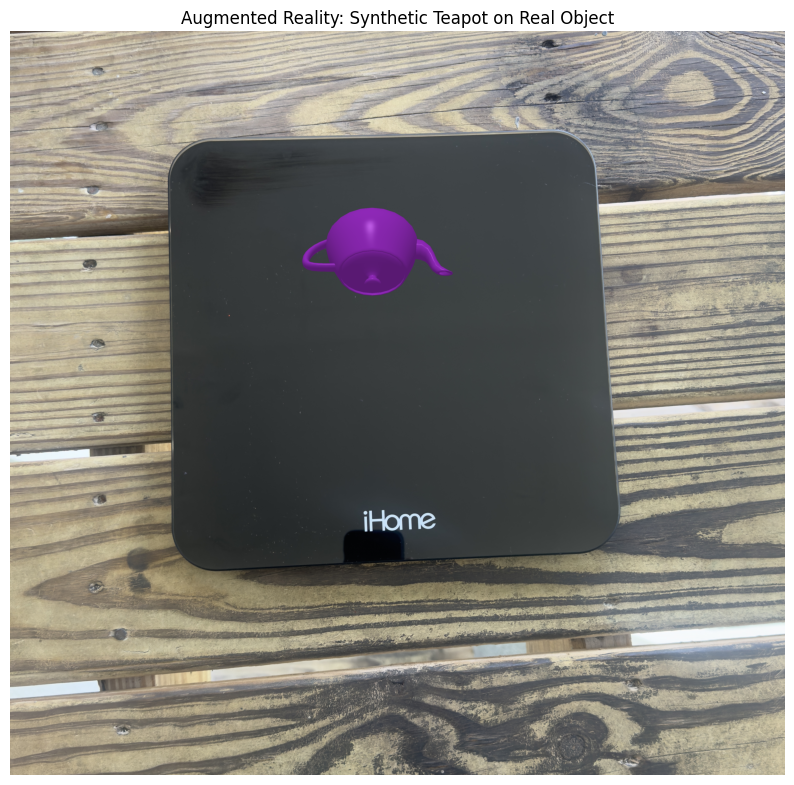

In [24]:
# --- 1. Render the Teapot ---
# This uses the renderer, mesh, and camera you've already set up
rendered_images = renderer(mesh)

# Extract the RGB image and the alpha channel (mask)
rendered_rgb = rendered_images[0, ..., :3].cpu().numpy()  # The color part
alpha_mask = rendered_images[0, ..., 3].cpu().numpy()     # The transparency part


# --- 2. Prepare for Compositing ---
# Convert the original image to a 0-1 float format
original_image_float = image_rgb / 255.0

# Create a 3-channel mask from the alpha channel
# This allows us to blend RGB images
mask = (alpha_mask > 0)[..., None]


# --- 3. Composite the Images ---
# Where the mask is True, we take the rendered image.
# Where the mask is False, we keep the original image.
final_image = original_image_float * (1 - mask) + rendered_rgb * mask


# --- 4. Display the Final Result ---
print("🖼️ Here is your final augmented reality image!")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.title("Augmented Reality: Synthetic Teapot on Real Object")
plt.axis('off')
plt.show()